In [1]:
import glob
import pickle
import pandas as pd

from tools.network_analysis import *
from tools.utils import *
from tools.accessibility import *
from tools.gtfs import *

from joblib import Parallel, delayed
import itertools


import matplotlib.pyplot as plt
import random
import time

In [2]:
zs = gpd.read_file('data/zona_Oeste')
G = pickle.load(open('data/SP-Oeste.graph','rb'))
walk_speed = 3.5#km/h
for e in G.edges:
    G.edges[e]['time_sec'] = G.edges[e]['length']/(walk_speed/3.6)
    G.edges[e]['etype'] = 'walk'

In [3]:
routes = read_gtfs_as_graphs('data/sp_gtfs.zip')

In [4]:
get_closest_nodes(G, routes)
# filter routes with few stops in the area
routes = [n for n in routes 
         if len([i for i in n.nodes 
                 if n.nodes[i]['attached'] 
                 is not None]) / 
            len(n.nodes) >= .85]

Text(0.5, 1.0, 'Traffic zones and walking network')

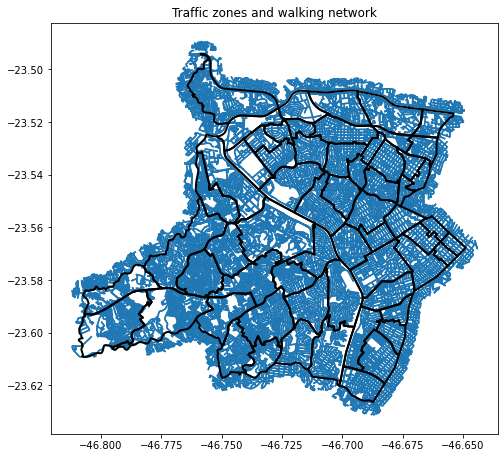

In [5]:
edges = ox.graph_to_gdfs(G, nodes=False)
ax = zs.plot(color=(0,0,0,0), edgecolor='k', linewidth=2, figsize=(8,8))
edges.plot(ax=ax, zorder=0)
plt.title('Traffic zones and walking network')

# This section defines funcitons for GA

In [6]:
def calc_boarding_cost(cycle, cars, ceil_to_closest=1,
                       min_hway=300):
    hway = cycle / cars
    # round up to closest multiple
    hway = ceil(hway / ceil_to_closest) * ceil_to_closest
    return min(hway, min_hway)

def update_log(G, log, route_cars, ceil_to_closest=1,
                      min_hway=300, copy = False):
    if copy:
        G = G.copy()
    for route, cars in route_cars.items():
        cycle = log[route]['cycle_time']
        b_edges = log[route]['boarding_edges']
        for e in b_edges:
            t = calc_boarding_cost(cycle, cars, 
                                  ceil_to_closest=ceil_to_closest,
                                  min_hway=min_hway)
            
            b_edges[e]['time_sec'] = t
        nx.set_edge_attributes(G, b_edges)
    return G

In [7]:
def _buses_per_route(s, original_buses):
    rs, counts = np.unique(s, return_counts=True)
    return {r : b + original_buses[r] for r,b in zip(rs, counts)}

In [8]:
# check performance for average accessibility optimization
def _performance_check(s, log, G, gdf, targets, 
                       z_nodes, vals, weight='time_sec',
                       original_buses=None,
                       opportunities_column='jobs', 
                       population_column=None, 
                       inplace=True, seed=None,
                       k=5, weights='time_sec',
                       decay_func=soft_threshold, 
                       decay_kws={'t':3600}):
    
    if original_buses is None:
        original_buses = {}.fromkeys(log, 0)
    route_cars = _buses_per_route(s, original_buses)
    
    #copy before updating
    log = log.copy()
    G = G.copy()
    update_log(G, log, route_cars)
    acc = accessibility(gdf, G, weight=weight, k=k, seed=seed, 
                        opportunities_column=opportunities_column,
                        decay_func=decay_func, decay_kws=decay_kws,
                        population_column=population_column,
                        targets=targets, z_nodes=z_nodes, 
                        vals=vals)
    #weight by population
    if population_column is None:
        weights = [1]*len(acc)
    else:
        weights = gdf[population_column]
    return np.average(list(acc.values()), weights=weights)

In [9]:
# check performance for max 1-Gini
def _performance_check_equality(s, log, G, gdf, targets, 
                       z_nodes, vals, weight='time_sec',
                       original_buses=None,
                       opportunities_column='jobs', 
                       population_column=None, 
                       inplace=True, seed=None,
                       k=5, weights='time_sec',
                       decay_func=soft_threshold, 
                       decay_kws={'t':3600}):
    
    if original_buses is None:
        original_buses = {}.fromkeys(log, 0)
    route_cars = _buses_per_route(s, original_buses)
    
    #copy before updating
    log = log.copy()
    G = G.copy()
    update_log(G, log, route_cars)
    acc = accessibility(gdf, G, weight=weight, k=k, seed=seed, 
                        opportunities_column=opportunities_column,
                        decay_func=decay_func, decay_kws=decay_kws,
                        population_column=population_column,
                        targets=targets, z_nodes=z_nodes, 
                        vals=vals)
    #weight by population
    if population_column is None:
        weights = [1]*len(acc)
    else:
        weights = gdf[population_column]
    return 1-gini(list(acc.values()), weights=weights)

In [10]:
def selection(pop, scores, k=3):
    selection_ix = random.randint(0,len(pop)-1)
    for ix in np.random.randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

def crossover(gene1,gene2,rate):
    if random.random()<rate:
        c1,c2=[],[]
        pt = random.randint(1, len(gene1)-2)
        c1 += gene1[:pt] + gene2[pt:]
        c2 += gene2[:pt] + gene1[pt:]
        return [c1, c2]
    else:
        return [gene1,gene2]
    
def mutation(a, possible, r_mut=.01):
    a=a.copy()
    for i in range(len(a)):
        # check for a mutation
        if random.random() < r_mut:
            a[i] = random.choice(possible)
    return a

In [11]:
def GA(func, G, routes, gdf, bus_num, buses=None, population=32, prefix='', 
       seed=None, crossover_rate=.9, generations=100, r_mut=.01, func_kws={}, k=5,
       take=2, first_guesses=None, save=True, saveeach=1, parallel=True, workers=-1,
       init_density=.3, fail_scaling=0, magnitude_scaling=0, population_column='População'):
    
    G = G.copy()
    possible = [L.graph['route_id'] for L in routes]
    # prepare first set of random genes
    # start with random population
    random.seed(seed)
    np.random.seed(seed)
    
    # First guesses are used to continue from some guesses. 
    # If no guesses are provided, start with random genes.
    if first_guesses is None:
        first_guesses=[]
    sets = first_guesses.copy()
    sets += [[random.choice(possible) for n in range(bus_num)] 
             for n in range(population-len(first_guesses))]
    # prepare accessibility resources
    # target nodes must be in walk graph
    targets, z_nodes, vals = get_reference_nodes(gdf, G, k=k,
                                                 seed=seed,
                                                 return_ref_values=True,
                                                 ref_val_column=['População', 'jobs'])
    # prepare transit graph
    log = {}
    for L in routes:
        add_transit_route(G, L, log=log)
        
    gen = 0
    while True:
        t=time.time()
        
        #parallel:
        if not parallel:
            workers = 1
        # get individual scores
        scores = Parallel(n_jobs=workers)(delayed(func)(s, log, G, gdf, targets, 
                                                        z_nodes, vals,
                                                        original_buses=buses,
                                                        opportunities_column='jobs', 
                                                        population_column='População', 
                                                        inplace=True, seed=1,
                                                        k=5, weights='time_sec',
                                                        decay_func=cumulative, 
                                                        decay_kws={'t':1800})
                                          for s in sets)
        #run selection
        top_choices = [selection(sets,scores) for _ in range(population)]
        if gen >= generations:
            break
        #do crossover
        set_dict = {n:s for n,s in zip(range(len(sets)),sets)}
        sets = []
        for i0 in range(0, population, 2):
            # get selected parents in pairs
            p1, p2 = top_choices[i0], top_choices[i0+1]
            # crossover and mutation
            for c in crossover(p1, p2, crossover_rate):
                # mutation
                c = mutation(c, possible, r_mut)
                # store for next generation
                sets.append(c)
        #apply elitism
        if take > 0:
            sets[:take] = [set_dict[n] for _,n in 
                           sorted(zip(scores,range(len(sets))))[-take:]]
        
        # print results
        print(f'gen {gen}\ttop: {max(scores):.03f}\t',
              f'pop: {len(scores)}\t',
              f'iter time: {time.time()-t:.00f}s',
              f'\testimated time: {(time.time()-t)*(generations-(gen))/60: .00f}min',
              sep = '')
        if (gen)%saveeach==0:
            pickle.dump((sets,scores),open(f'results/{prefix}_gen{gen}.dat','wb'))
        gen+=1
    
    pickle.dump((sets,scores),open(f'results/{prefix}_gen{gen}.dat','wb'))
    print(f'gen {gen}\ttop: {max(scores):.03f}\t',
          f'pop: {len(scores)}\t',
          f'iter time: {time.time()-t:.00f}s',
          f'\testimated time: {(time.time()-t)*(generations-(gen))/60: .00f}min',
          sep = '')
    return sets,scores

In [12]:
for L in routes:
    add_transit_route(G, L)

In [13]:
for e in G.edges:
    if 'etype' not in G.edges[e]:
        G.edges[e]['etype'] = 'bus_line'

In [14]:
edges = ox.graph_to_gdfs(G, nodes=False)

Text(0.5, 1.0, 'Walking and transit networks')

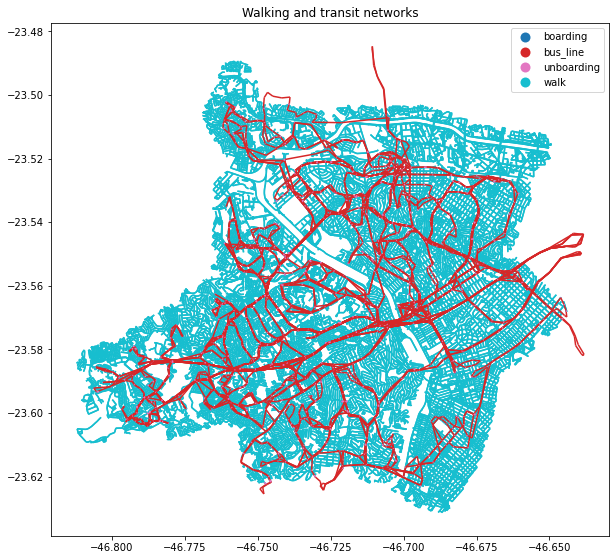

In [15]:
edges.plot(column='etype', legend=True, figsize=(10,10))
plt.title('Walking and transit networks')

In [16]:
# estimate the current system's buses per route
buses = {}
for route in routes:
    # number of buses depends on cycle time, frequency, and
    # additional time for schedule corrections (600sec)
    buses[route.graph['name']] = round((route.graph['cycle_time']+600)/route.graph['headway'])

In [17]:
buses

{'199D-10': 19,
 '6250-10': 5,
 '6262-10': 14,
 '8610-10': 15,
 '775V-10': 7,
 '6412-10': 12,
 '7040-21': 2,
 '775A-10': 6,
 '775F-10': 26,
 '9050-10': 11,
 '177Y-10': 13,
 '809A-10': 16,
 '809D-10': 10,
 '809R-10': 6,
 '846M-10': 5,
 '9051-10': 5,
 '7282-10': 5,
 '8700-21': 1,
 '8700-24': 1,
 '7903-10': 8,
 '7545-10': 23,
 '8705-10': 14,
 '809T-10': 9,
 '8252-10': 2,
 '8001-10': 4,
 '8003-10': 6,
 '8060-10': 9,
 '8062-10': 2,
 '8038-10': 23,
 '809H-10': 13,
 '748A-10': 8,
 '748A-41': 4,
 '748R-10': 25,
 '8319-10': 9,
 '778J-10': 8,
 '778J-41': 13,
 '809U-10': 4,
 '809U-21': 15,
 '6232-10': 4,
 '874C-10': 9,
 '714C-10': 8,
 '775P-10': 7,
 '809V-10': 6,
 '7002-10': 21,
 '771P-10': 5,
 '8012-10': 11,
 '8022-10': 14,
 '8032-10': 4,
 '7725-10': 3,
 '8019-10': 6,
 '8021-10': 2,
 '8027-10': 4,
 '809N-10': 6,
 '817C-10': 12,
 '6418-10': 5,
 '7458-10': 7,
 '8023-10': 4,
 '8025-10': 5,
 '8073-10': 8,
 '8077-10': 5,
 '775N-10': 5,
 '8030-10': 8,
 '8029-10': 8,
 '809J-10': 4,
 '756A-10': 17,
 '80

In [19]:
# optimize for accessibility
generations = 25
population = 6
func = _performance_check
# no first guesses
first_guesses = []
seed = 1
# number of additional buses
# as an example, we set to 100
bus_num = 100

sets, scores=GA(func, G, routes, zs, bus_num, population=population,
                parallel=True, generations=generations, take=1, buses=buses,
                prefix=f'MaxAcc_{bus_num:03d}_', workers=-1, seed=seed,
                r_mut=.01, population_column='População')

gen 0	top: 19075.360	pop: 6	iter time: 16s	estimated time:  7min
gen 1	top: 19177.751	pop: 6	iter time: 15s	estimated time:  6min
gen 2	top: 19177.751	pop: 6	iter time: 13s	estimated time:  5min
gen 3	top: 19239.758	pop: 6	iter time: 12s	estimated time:  5min
gen 4	top: 19239.758	pop: 6	iter time: 12s	estimated time:  4min
gen 5	top: 19239.758	pop: 6	iter time: 12s	estimated time:  4min
gen 6	top: 19239.758	pop: 6	iter time: 13s	estimated time:  4min
gen 7	top: 19239.758	pop: 6	iter time: 13s	estimated time:  4min
gen 8	top: 19395.526	pop: 6	iter time: 13s	estimated time:  4min
gen 9	top: 19621.200	pop: 6	iter time: 13s	estimated time:  3min
gen 10	top: 19621.200	pop: 6	iter time: 13s	estimated time:  3min
gen 11	top: 19621.200	pop: 6	iter time: 13s	estimated time:  3min
gen 12	top: 19622.781	pop: 6	iter time: 13s	estimated time:  3min
gen 13	top: 19723.666	pop: 6	iter time: 13s	estimated time:  3min
gen 14	top: 19731.467	pop: 6	iter time: 13s	estimated time:  2min
gen 15	top: 19771.13

In [ ]:
# optimize for equality
generations = 25
population = 6
func = _performance_check_equality
seed = 1
# number of additional buses
# as an example, we set to 100
bus_num = 100

sets, scores=GA(func, G, routes, zs, bus_num, population=population,
                parallel=True, generations=generations, take=1, buses=buses,
                prefix=f'MaxEqu_{bus_num:03d}_', workers=-1, seed=seed,
                r_mut=.01, population_column='População')

gen 0	top: 0.358	pop: 6	iter time: 13s	estimated time:  6min
gen 1	top: 0.358	pop: 6	iter time: 13s	estimated time:  5min
gen 2	top: 0.358	pop: 6	iter time: 13s	estimated time:  5min
gen 3	top: 0.358	pop: 6	iter time: 13s	estimated time:  5min
gen 4	top: 0.360	pop: 6	iter time: 13s	estimated time:  5min
gen 5	top: 0.360	pop: 6	iter time: 13s	estimated time:  4min
gen 6	top: 0.360	pop: 6	iter time: 13s	estimated time:  4min
gen 7	top: 0.360	pop: 6	iter time: 13s	estimated time:  4min
gen 8	top: 0.361	pop: 6	iter time: 12s	estimated time:  4min
gen 9	top: 0.361	pop: 6	iter time: 12s	estimated time:  3min
gen 10	top: 0.362	pop: 6	iter time: 12s	estimated time:  3min
gen 11	top: 0.362	pop: 6	iter time: 12s	estimated time:  3min
gen 12	top: 0.362	pop: 6	iter time: 12s	estimated time:  3min
gen 13	top: 0.362	pop: 6	iter time: 12s	estimated time:  2min
gen 14	top: 0.362	pop: 6	iter time: 13s	estimated time:  2min
gen 15	top: 0.362	pop: 6	iter time: 13s	estimated time:  2min
gen 16	top: 0.364	